### Preprocessing

We will train with full data using multiple workers in cloud. To preprocess 8000 intances, it takes about 2~3 hours with 10 workers.

In [1]:
import mltoolbox.image.classification as model
from datalab.ml import *
import os

bucket = 'gs://' + datalab_project_id() + '-coast'
preprocessed_dir = bucket + '/preprocessed'
staging_dir = bucket + '/staging'
model_dir = bucket + '/model'

In [1]:
train_set = BigQueryDataSet('SELECT image_url, label FROM coast.train')
model.preprocess(train_set, preprocessed_dir, cloud={'num_workers': 10}).wait()

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning:

Using fallback coder for typehint: Any.



Job "preprocess-inception-170215-190627" submitted. Click here to track preprocessing job.

### Training

If it is the first time training for a while, warm-up takes about 5~10 minutes so the whole training takes about 20 minutes. On subsequent trainings, warm up time is about 1 minute.

In [3]:
model.train(preprocessed_dir, 64, 8000, model_dir,
            cloud=CloudTrainingConfig('us-central1', 'BASIC')).wait()

Job "inception_train_170216_235400" submitted. Click here to view cloud log.

Check your job status.

In [4]:
Job('inception_train_170216_235400').describe()

createTime: '2017-02-16T23:54:01Z'
endTime: '2017-02-17T00:05:06Z'
jobId: inception_train_170216_235400
startTime: '2017-02-16T23:54:48Z'
state: SUCCEEDED
trainingInput:
  args:
  - --checkpoint
  - gs://cloud-ml-data/img/flower_photos/inception_v3_2016_08_28.ckpt
  - --input_dir
  - gs://bradley-playground-coast/preprocessed
  - --max_steps
  - '8000'
  - --output_path
  - gs://bradley-playground-coast/model
  - --batch_size
  - '64'
  packageUris:
  - gs://cloud-datalab/deploy/tf/tensorflow-1.0.0rc1-cp27-none-linux_x86_64.whl
  - gs://bradley-playground-coast/model/staging/inception.tar.gz
  pythonModule: datalab_solutions.inception.task
  region: us-central1
trainingOutput:
  consumedMLUnits: 0.17



### Evaluation

First, we can check the TF summary events from training.

In [5]:
summary = Summary(model_dir)
summary.list_events()

{u'accuracy': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'batch/fraction_of_448_full': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'global_step/sec': {u'gs://bradley-playground-coast/model/train'},
 u'input_producer/fraction_of_32_full': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'},
 u'loss': {u'gs://bradley-playground-coast/model/eval_set',
  u'gs://bradley-playground-coast/model/train_set'}}

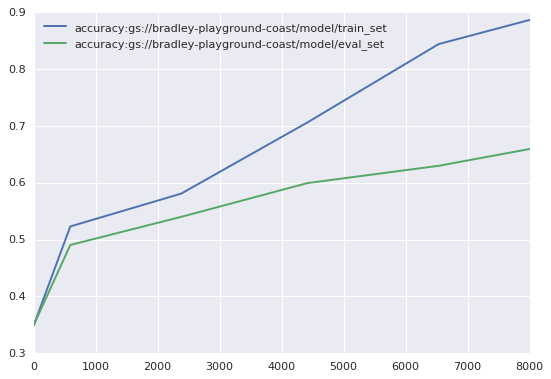

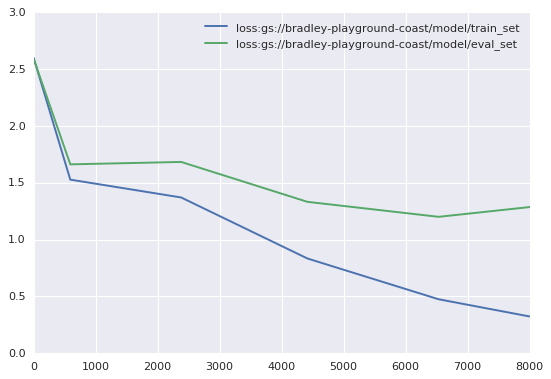

In [6]:
summary.plot('accuracy')
summary.plot('loss')

### Model Deployment

Deploy the model so we can do online prediction.

In [7]:
Models().create('coast')
ModelVersions('coast').deploy('v5', model_dir)

Waiting for operation "projects/bradley-playground/operations/create_coast_v5-1487290323936"
Done.


In [8]:
ModelVersions('coast').describe('v5')

createTime: '2017-02-17T00:12:03Z'
deploymentUri: gs://bradley-playground-coast/model/model
name: projects/bradley-playground/models/coast/versions/v5



### Online Prediction

Predicting...


10A(0.83495)

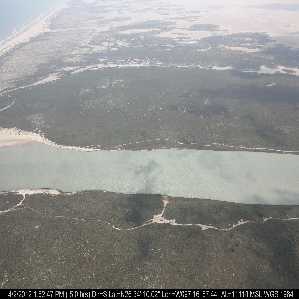

10A(0.97475)

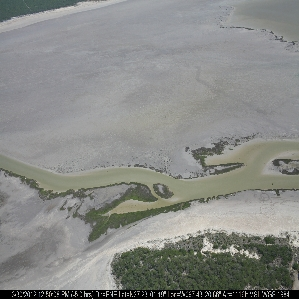

7(0.72879)

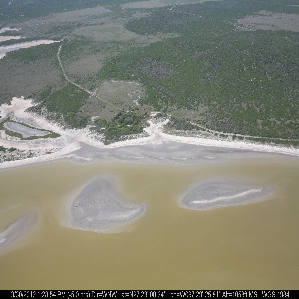

10A(0.84719)

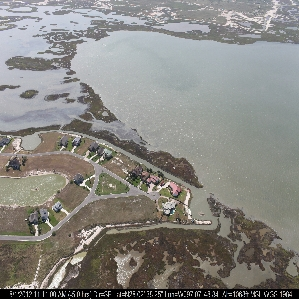

Done


In [2]:
# gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg,3B
# gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg,10A
# gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg,7
# gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg,10A
images = [
  'gs://tamucc_coastline/esi_images/IMG_2849_SecDE_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0047_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_0617_SecBC_Spr12.jpg',
  'gs://tamucc_coastline/esi_images/IMG_2034_SecEGH_Sum12_Pt2.jpg'
]
# resize=True because otherwise the images are too large to send for online prediction.
model.predict('coast.v5', images, resize=True, cloud=True)

### Batch Prediction

In [10]:
eval_set = BigQueryDataSet(sql='select * from coast.eval')
model.batch_predict(eval_set, model_dir, staging_dir, output_bq_table='coast.eval_results_full',
                    cloud={'num_workers': 10}).wait()

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:136: UserWarning:

Using fallback coder for typehint: Any.



Job "batch-predict-inception-170217-004014" submitted. Click here to track batch prediction job.

Check evaluation results. It is much better than local run results --- of course, we used much more data, and we ran more training steps.

In [2]:
%%sql --module accuracy
SELECT
  target,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target == predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy,
FROM
  coast.eval_results_full
GROUP BY
  target

In [3]:
%%bigquery execute -q accuracy

target,correct,total,accuracy
1,23,51,0.450980392157
5,51,96,0.53125
7,44,65,0.676923076923
9,101,165,0.612121212121
2A,52,179,0.290502793296
3A,117,137,0.85401459854
3B,83,124,0.66935483871
6A,54,91,0.593406593407
6B,39,81,0.481481481481
8A,100,124,0.806451612903


In [13]:
%%sql --module logloss

SELECT feature, AVG(-logloss) as logloss, count(*) as count FROM
(
  SELECT feature, CASE WHEN correct == 1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss,
  FROM
  (
    SELECT
    target as feature, 
    CASE WHEN target == predicted THEN 1 ELSE 0 END as correct,
    target_prob as prob
    FROM coast.eval_results_full
  )
)
GROUP BY feature

In [14]:
FeatureSliceView().plot(logloss)